In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
from solvers import * 

In [3]:
from plot import * 

In [23]:
N = 1366417755
R0 = 9059
I0 = 24653
Istar = 300000
print(Istar)

r = 4.2
e = r/Istar
gamma = 1/5.
S0 = N - I0 - R0
beta0 = gamma*N/S0
# Istar = r/e
Jstar = gamma*N
init = (S0, I0, R0)
delta_t = 0.001

tsteps = 500
t = np.linspace(0, tsteps-1, tsteps)
eta = 1
# i = np.zeros(tsteps)
spikes = [(50, 0), (100, 0)]
# for (pos, spike) in spikes:
#     i[pos] = spike

300000


In [80]:
R_intervention_h = 0.8
R_intervention_l = 0.5
beta_intervention_h = R_intervention_h*gamma
beta_intervention_l = R_intervention_l*gamma
R_relaxation = 2.2
beta_relaxation = R_relaxation*gamma
beta_dI_h = []
beta_dI_l = []
T_intervention = 60
T_relaxation = 30
temp = 0
while temp < tsteps:
    if(temp+T_intervention>=tsteps):
        beta_dI_h.extend([beta_intervention_h for i in range(tsteps - temp)])
        beta_dI_l.extend([beta_intervention_l for i in range(tsteps - temp)])
        temp += tsteps - temp
    else:
        beta_dI_h.extend([beta_intervention_h for i in range(T_intervention)])
        beta_dI_l.extend([beta_intervention_l for i in range(T_intervention)])
        beta_dI_h.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))]) 
        beta_dI_l.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))])
        temp += T_intervention + min(T_relaxation, tsteps - temp)
beta_dI_h = np.array(beta_dI_h)
beta_dI_l = np.array(beta_dI_l)

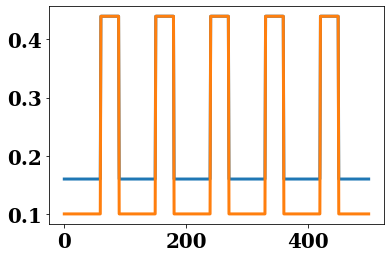

In [81]:
plt.plot(t, beta_dI_h)
plt.plot(t, beta_dI_l)

In [82]:
# sigma = 1/5.
# epsilon = 1/5.
# S, E, I, R = solve_discrete_SEIR((S0, 1*I0, I0, R0), 2*gamma, gamma, sigma, N, tsteps, delta_t=delta_t)
S_dI_h, I_dI_h, R_dI_h = solve_discrete_sir((S0, I0, R0), beta_dI_h, gamma, N, tsteps, delta_t=delta_t)
S_dI_l, I_dI_l, R_dI_l = solve_discrete_sir((S0, I0, R0), beta_dI_l, gamma, N, tsteps, delta_t=delta_t)
# S, E, I, H, R = solve_discrete_SEIHR((S0, 100, I0, 0, R0), beta, gamma, sigma, epsilon, N, tsteps, delta_t=delta_t)


In [83]:
S_cons, I_cons, R_cons = solve_discrete_sir((S0, I0, R0), 2.2*gamma, gamma, N, tsteps, delta_t=delta_t)

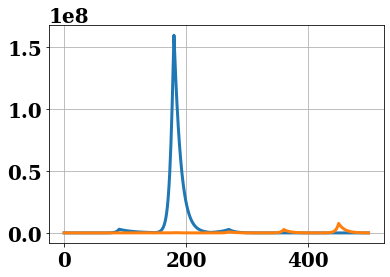

In [84]:
# plt.plot(t, S)
plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9]) 
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, I_dI_h)
plt.plot(t, I_dI_l)
# plt.plot(t, R)

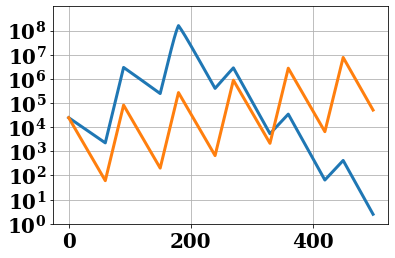

In [85]:
# plt.plot(t, S)
plt.grid()
plt.yscale("log")
plt.ylim([1, 1e+9])
plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, I_dI_h)
plt.plot(t, I_dI_l)
# plt.plot(t, R)

In [86]:
def find_approximation(beta, klevels, loss_function):
    """
        Find the best approximation of beta (m,) sized array
        based on one of the klevels (k,) sized array. The
        goodness of approximation is based on 

        loss_function: (y, y_hat) -> R (positive reals)

        Returns: beta_approx (m,) sized array
        such that: 
            
            \sum_t loss_function(beta_approx(t), beta(t))
        i.e. pointwise loss values are minimized.

        Since, loss_function is positive and pointwise,
        elementwise minimum should minimise the global objective.

        TODO: Should we impose some sort of smoothness constraint
        on beta_approx(t) ?
    """
    num_steps = np.shape(beta)[0]
    num_levels = np.shape(klevels)[0]
    
    #TODO: Try out a vectorized implementation
    beta_approx = []
#     lower_buildup = 0
    for t in range(num_steps):
        beta_val = beta[t]
        losses = loss_function(beta_val, klevels)
        best_beta = klevels[np.argmin(losses)]
#         if(lower_buildup > 2 and np.argmin(losses) != num_levels -1):
#             best_beta = klevels[np.argmin(losses)+1]
#             lower_buildup -=1
#         if(lower_buildup < -2 and np.argmin(losses) != 0):
#             best_beta = klevels[np.argmin(losses)-1]
#             lower_buildup +=1
            
#         if(best_beta < beta_val):
#             lower_buildup += 2
#         if(best_beta > beta_val):
#             lower_buildup -= 2
        beta_approx.append(best_beta)

    beta_approx = np.array(beta_approx)
    return beta_approx

In [87]:
S_ideal, I_ideal, R_ideal, beta_ideal = solve_sir_lv_control(S0, I0, R0, beta0, N, r, e, gamma, eta, t)

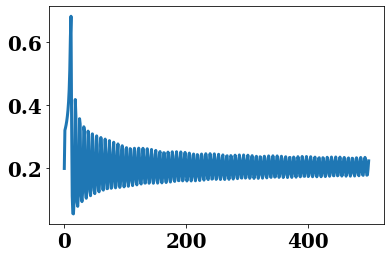

In [88]:
plt.plot(t, beta_ideal)

In [89]:
klevels = np.array([0.1*i for i in range(1,6)])
# klevels = [2.2*gamma, 0.8*gamma]
loss_function = lambda x,y: (x-y)**2
beta_approx = find_approximation(beta_ideal, klevels, loss_function)

In [90]:
S_approx, I_approx, R_approx = solve_discrete_sir((S0, I0, R0), beta_approx, gamma, N, tsteps, delta_t=delta_t)

In [91]:
df = pd.read_csv('./india_case_counts.csv')
I_real = df.iloc[91:]['Active Infections']

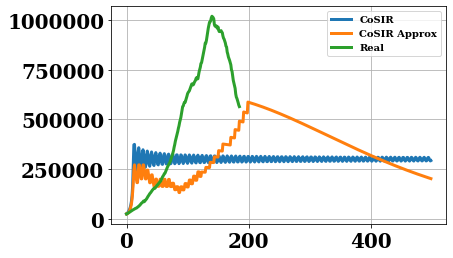

In [92]:
plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# plt.plot(t, S, label="CoSIR")
# plt.plot(t, S_approx, label="CoSIR Approx")
# plt.plot(t, S_dI, label = "Dynamic Intervention")
plt.plot(t, I_ideal, label="CoSIR")
plt.plot(t, I_approx, label="CoSIR Approx")
# plt.plot(t, I_cons, label= r'Constant \beta')
# plt.plot(t, I_dI, label = "Dynamic Intervention")
plt.plot(range(len(I_real)), I_real, label = "Real")
plt.legend(prop={'size': 10})
# plt.plot(t, R)

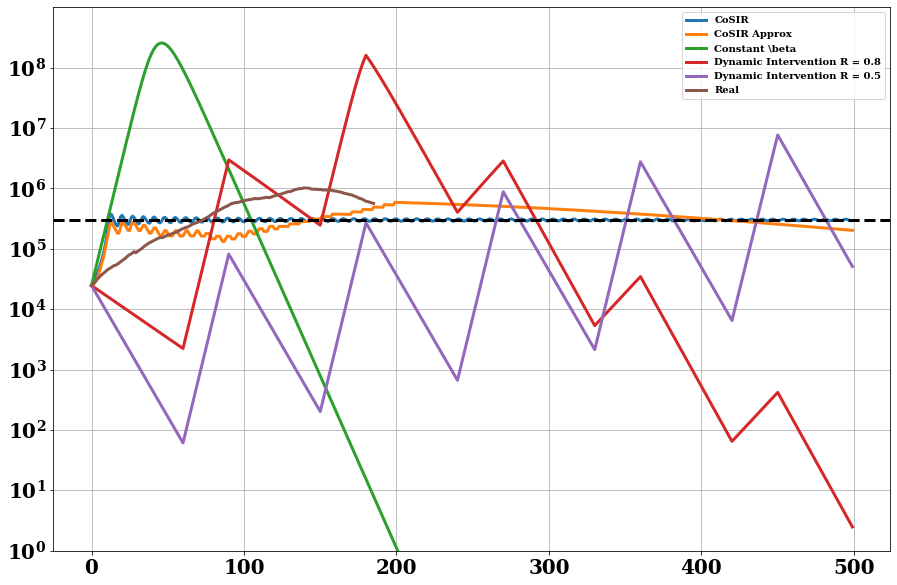

In [93]:
plt.figure(figsize = (15, 10))
plt.grid()
plt.yscale("log")
plt.ylim([1, 1e+9])
plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# plt.plot(t, S, label="CoSIR")
# plt.plot(t, S_approx, label="CoSIR Approx")
# plt.plot(t, S_dI, label = "Dynamic Intervention")
plt.plot(t, I_ideal, label="CoSIR")
plt.plot(t, I_approx, label="CoSIR Approx")
plt.plot(t, I_cons, label= r'Constant \beta')
plt.plot(t, I_dI_h, label = "Dynamic Intervention R = 0.8")
plt.plot(t, I_dI_l, label = "Dynamic Intervention R = 0.5")
plt.axhline(y=Istar, linestyle = '--', color = 'black')
plt.plot(range(len(I_real)), I_real, label = "Real")
plt.legend(loc = 'upper right', prop={'size': 10})
# plt.plot(t, R)

In [94]:
def getControlMetrics(I, Istar):
    c = 0
    for i in I:
        c += np.abs(i-Istar)
    return c/Istar

In [95]:
# print("Constant beta:{:.2E}".format(getControlMetrics(I_cons, Istar)))
# print("Ideal beta:{:.2E}".format(getControlMetrics(I_ideal, Istar)))
# print("Approx beta:{:.2E}".format(getControlMetrics(I_approx, Istar)))
# print("Dynamic Intervention beta:{:.2E}".format(getControlMetrics(I_dI, Istar)))
# # print("Real:", getControlMetrics(I_real[:180], Istar))

In [97]:
l = len(I_real)
print("Constant beta: {}".format(getControlMetrics(I_cons[:l], Istar)))
print("Ideal beta: {}".format(getControlMetrics(I_ideal[:l], Istar)))
print("Approx beta: {}".format(getControlMetrics(I_approx[:l], Istar)))
print("Dynamic Intervention beta R=0.8: {}".format(getControlMetrics(I_dI_h[:l], Istar)))
print("Dynamic Intervention beta R=0.5: {}".format(getControlMetrics(I_dI_l[:l], Istar)))
print("Real: {}".format(getControlMetrics(I_real, Istar)))

Constant beta: 19189.60630931774
Ideal beta: 18.641271330644226
Approx beta: 63.57224548932292
Dynamic Intervention beta R=0.8: 5571.316996730643
Dynamic Intervention beta R=0.5: 173.7086558821208
Real: 203.08077666666668


NameError: name 'beta_dI' is not defined

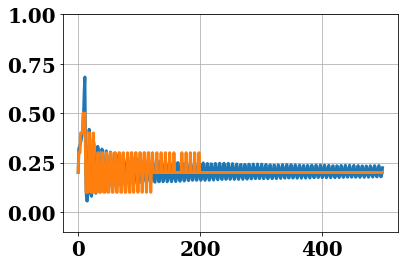

In [59]:
plt.grid()
# plt.yscale("log")
plt.ylim([-0.1, 1])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
plt.plot(t, beta_ideal, label="CoSIR")
plt.plot(t, beta_approx, label="CoSIR approx")
plt.plot(t, beta_dI, label = "Dynamic Intervention")
plt.legend(prop={'size': 10})
# plt.plot(t, R)

In [85]:
J_ideal = [beta_ideal[i]*S_ideal[i] for i in range(len(S_ideal))]

In [86]:
S_ideal

array([1.36638404e+09, 1.36635694e+09, 1.36617110e+09, 1.36576674e+09,
       1.36572697e+09, 1.36572430e+09, 1.36572369e+09, 1.36572329e+09,
       1.36572267e+09, 1.36572075e+09, 1.36571066e+09, 1.36563520e+09,
       1.36533412e+09, 1.36522398e+09, 1.36521214e+09, 1.36520921e+09,
       1.36520723e+09, 1.36520419e+09, 1.36519521e+09, 1.36515265e+09,
       1.36495591e+09, 1.36476744e+09, 1.36473488e+09, 1.36472767e+09,
       1.36472366e+09, 1.36471852e+09, 1.36470579e+09, 1.36465554e+09,
       1.36447028e+09, 1.36430555e+09, 1.36427072e+09, 1.36426129e+09,
       1.36425532e+09, 1.36424709e+09, 1.36422615e+09, 1.36414888e+09,
       1.36395135e+09, 1.36383844e+09, 1.36381260e+09, 1.36380295e+09,
       1.36379491e+09, 1.36378139e+09, 1.36374313e+09, 1.36361712e+09,
       1.36343941e+09, 1.36337675e+09, 1.36335907e+09, 1.36334926e+09,
       1.36333781e+09, 1.36331341e+09, 1.36323879e+09, 1.36306792e+09,
       1.36295482e+09, 1.36292241e+09, 1.36290903e+09, 1.36289761e+09,
      

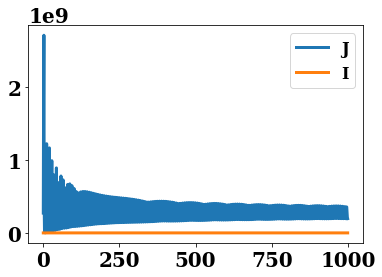

In [87]:
plt.plot(t, J_ideal, label= "J")
plt.plot(t, I_ideal, label= "I")
plt.legend()

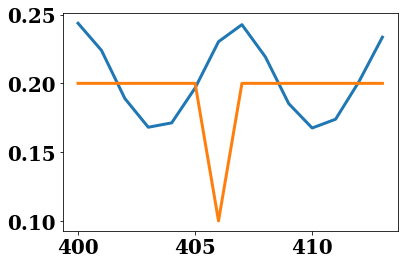

In [481]:
plt.plot(t[400:414], beta_ideal[400:414], label="CoSIR")
plt.plot(t[400:414], beta_approx[400:414], label="CoSIR approx")

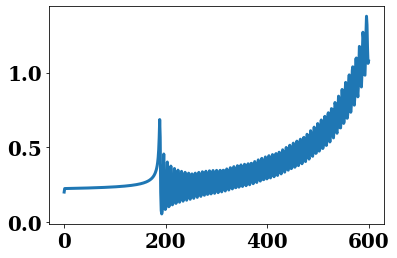

In [192]:
plt.plot(t, beta_ideal, label="CoSIR approx")

In [243]:
df = pd.read_csv('./india_case_counts.csv')

In [251]:
df.iloc[91:]['Active Infections']

91      24653
92      26010
93      27651
94      29552
95      32023
        ...  
272    605357
273    595693
274    584255
275    572332
276    564457
Name: Active Infections, Length: 186, dtype: int64

In [253]:
df.iloc[91:]

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Active Infections
91,30 April,2020-04-30,1801,34866,630,9059,75,1154,24653
92,01 May,2020-05-01,2396,37262,962,10021,77,1231,26010
93,02 May,2020-05-02,2564,39826,831,10852,92,1323,27651
94,03 May,2020-05-03,2952,42778,911,11763,140,1463,29552
95,04 May,2020-05-04,3656,46434,1082,12845,103,1566,32023
...,...,...,...,...,...,...,...,...,...
272,28 October,2020-10-28,50188,8039207,56594,7313872,515,119978,605357
273,29 October,2020-10-29,48765,8087972,57867,7371739,562,120540,595693
274,30 October,2020-10-30,48117,8136089,59005,7430744,550,121090,584255
275,31 October,2020-10-31,47228,8183317,58682,7489426,469,121559,572332


In [21]:
len(I_real)

186